# PyDart Library – Final Evaluation and Makespan Optimization

## Overview

This iteration represents the **most recent** version of PyDart, aligning closely with the final code used for **PyDart Eval testing**. The primary focus in this version was on **makespan-based scheduling**, which significantly improved results.

## Main Contributions

1. **Utilizing Makespan as a Load Metric**  
   - Defined **makespan** as the total execution time of the system or specific layers.  
   - Used makespan to **optimize workload distribution**, leading to improved performance.  

2. **Refining the Final Implementation**  
   - This version and the final work differ only in:  
     - **Aesthetic and clean code improvements.**  
     - **Commenting and naming adjustments.**  

3. **Experimenting with Blocking Stages and Layers**  
   - Analyzed how dependent layers impact overall makespan.  
   - Observed the effect of **stage blocking** on execution efficiency.  
   - Gained insights into interdependencies within DAG-based execution.  

## Key Insights and Next Steps  

- Makespan-based scheduling **yielded strong results**, validating its effectiveness in PyDart.  
- Future refinements could explore **dynamic load balancing** to further optimize performance.  

---

**Note**: This iteration is nearly identical to the final version, with only minor refinements. The focus was on **cleaning up the code** and improving clarity in comments and naming conventions.


In [ ]:
import os
import io
import copy
import time
import queue
import threading
import torch
import torch.fx as fx
import torch.nn as nn
import torch.profiler
import torch.cuda
import networkx as nx
import pandas as pd
from torch.fx import Node as FxNode
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from typing import Callable, Any, List, Dict, Optional, Set, Tuple

# ----------------------------------------------------------------------
# Node Class: Manages task execution on a particular CPU/GPU node.
# ----------------------------------------------------------------------
class Node:
    def __init__(self, node_id: str, cpus=None, gpu=None):
        self._node_id = node_id
        self._cpus = tuple(cpus or [])
        self._gpu = gpu
        self._original_affinity = os.sched_getaffinity(0)
        self._task_queue = queue.Queue()
        self._stop_signal = False
        self._worker_thread = threading.Thread(target=self._worker_loop, daemon=True)
        self._worker_thread.start()
        self.current_load = 0.0
        self.assigned_stages = []

    @property
    def node_id(self):
        return self._node_id

    @property
    def cpus(self):
        return self._cpus

    @property
    def gpu(self):
        return self._gpu

    def assign_task(self, func: Callable, *args, **kwargs) -> queue.Queue:
        result_queue = queue.Queue(maxsize=1)
        self._task_queue.put((func, args, kwargs, result_queue))
        return result_queue

    def stop(self):
        self._stop_signal = True
        self._task_queue.put(None)
        self._worker_thread.join()

    def _worker_loop(self):
        while not self._stop_signal:
            item = self._task_queue.get()
            if item is None:
                break
            func, args, kwargs, result_queue = item
            try:
                self._set_context()
                result = func(*args, **kwargs)
            except Exception as e:
                result = e
            finally:
                self._reset_context()
            result_queue.put(result)

    def _set_context(self):
        if self._cpus:
            os.sched_setaffinity(0, self._cpus)
        if self._gpu is not None and torch.cuda.is_available():
            torch.cuda.set_device(self._gpu)
            torch.cuda.synchronize(self._gpu)

    def _reset_context(self):
        os.sched_setaffinity(0, self._original_affinity)
        if self._gpu is not None and torch.cuda.is_available():
            torch.cuda.synchronize(self._gpu)

    @staticmethod
    def discover_nodes(disjoint: bool = True) -> List['Node']:
        nodes = []
        num_cpus = os.cpu_count() or 1
        ngpus = torch.cuda.device_count()
        if not disjoint:
            for core_id in range(num_cpus):
                nodes.append(Node(node_id=f"CPU-{core_id}", cpus=[core_id]))
            for g in range(ngpus):
                for core_id in range(num_cpus):
                    nodes.append(Node(node_id=f"GPU-{g}-CPU-{core_id}", cpus=[core_id], gpu=g))
        else:
            cpu_nodes = [Node(node_id=f"CPU-{i}", cpus=[i]) for i in range(num_cpus)]
            gpu_nodes = []
            for g in range(ngpus):
                if cpu_nodes:
                    cpu_node = cpu_nodes.pop()
                    gpu_nodes.append(Node(node_id=f"GPU-{g}-CPU-{cpu_node.cpus[0]}", cpus=[cpu_node.cpus[0]], gpu=g))
                else:
                    gpu_nodes.append(Node(node_id=f"GPU-{g}", cpus=[], gpu=g))
            # To prefer GPU nodes for CUDA operations, we can return GPU nodes first.
            nodes = gpu_nodes + cpu_nodes
        return nodes

    def __repr__(self):
        return f"Node({self._node_id}, cpus={self._cpus}, gpu={self._gpu})"


In [ ]:
# -*- coding: utf-8 -*-
"""Untitled26.ipynb

Automatically generated by Colab.

Original file is located at
    https://colab.research.google.com/drive/1aBGeWbMHUGe0Y_Fpwx66p5iWLvVqZkDa
"""

import os
import io
import copy
import time
import queue
import threading
import torch
import torch.fx as fx
import torch.nn as nn
import torch.profiler
import torch.cuda
import networkx as nx
import pandas as pd
from torch.fx import Node as FxNode
from torch.utils.data import DataLoader, TensorDataset
from torchvision import models
from typing import Callable, Any, List, Dict, Optional, Set, Tuple

# ----------------------------------------------------------------------
# Node Class: Manages task execution on a particular CPU/GPU node.
# ----------------------------------------------------------------------
class Node:
    def __init__(self, node_id: str, cpus=None, gpu=None):
        self._node_id = node_id
        self._cpus = tuple(cpus or [])
        self._gpu = gpu
        self._original_affinity = os.sched_getaffinity(0)
        self._task_queue = queue.Queue()
        self._stop_signal = False
        self._worker_thread = threading.Thread(target=self._worker_loop, daemon=True)
        self._worker_thread.start()
        self.current_load = 0.0
        self.assigned_stages = []

    @property
    def node_id(self):
        return self._node_id

    @property
    def cpus(self):
        return self._cpus

    @property
    def gpu(self):
        return self._gpu

    def assign_task(self, func: Callable, *args, **kwargs) -> queue.Queue:
        result_queue = queue.Queue(maxsize=1)
        self._task_queue.put((func, args, kwargs, result_queue))
        return result_queue

    def stop(self):
        self._stop_signal = True
        self._task_queue.put(None)
        self._worker_thread.join()

    def _worker_loop(self):
        while not self._stop_signal:
            item = self._task_queue.get()
            if item is None:
                break
            func, args, kwargs, result_queue = item
            try:
                self._set_context()
                result = func(*args, **kwargs)
            except Exception as e:
                result = e
            finally:
                self._reset_context()
            result_queue.put(result)

    def _set_context(self):
        if self._cpus:
            os.sched_setaffinity(0, self._cpus)
        if self._gpu is not None and torch.cuda.is_available():
            torch.cuda.set_device(self._gpu)
            torch.cuda.synchronize(self._gpu)

    def _reset_context(self):
        os.sched_setaffinity(0, self._original_affinity)
        if self._gpu is not None and torch.cuda.is_available():
            torch.cuda.synchronize(self._gpu)

    @staticmethod
    def discover_nodes(disjoint: bool = True) -> List['Node']:
        nodes = []
        num_cpus = os.cpu_count() or 1
        ngpus = torch.cuda.device_count()
        if not disjoint:
            for core_id in range(num_cpus):
                nodes.append(Node(node_id=f"CPU-{core_id}", cpus=[core_id]))
            for g in range(ngpus):
                for core_id in range(num_cpus):
                    nodes.append(Node(node_id=f"GPU-{g}-CPU-{core_id}", cpus=[core_id], gpu=g))
        else:
            cpu_nodes = [Node(node_id=f"CPU-{i}", cpus=[i]) for i in range(num_cpus)]
            gpu_nodes = []
            for g in range(ngpus):
                if cpu_nodes:
                    cpu_node = cpu_nodes.pop()
                    gpu_nodes.append(Node(node_id=f"GPU-{g}-CPU-{cpu_node.cpus[0]}", cpus=[cpu_node.cpus[0]], gpu=g))
                else:
                    gpu_nodes.append(Node(node_id=f"GPU-{g}", cpus=[], gpu=g))
            # To prefer GPU nodes for CUDA operations, we can return GPU nodes first.
            nodes = gpu_nodes + cpu_nodes
        return nodes

    def __repr__(self):
        return f"Node({self._node_id}, cpus={self._cpus}, gpu={self._gpu})"


# ----------------------------------------------------------------------
# Utility Functions
# ----------------------------------------------------------------------
def resolve_arg(arg: Any, node_outputs: Dict[str, torch.Tensor]) -> Any:
    if isinstance(arg, FxNode):
        return node_outputs.get(arg.name, arg)
    elif isinstance(arg, (list, tuple)):
        return type(arg)(resolve_arg(a, node_outputs) for a in arg)
    elif isinstance(arg, dict):
        return {k: resolve_arg(v, node_outputs) for k, v in arg.items()}
    else:
        return arg

def move_tensor_to_device(obj, device):
    if isinstance(obj, torch.Tensor):
        return obj.to(device,non_blocking=True) if obj.device != device else obj
    elif isinstance(obj, (list, tuple)):
        return type(obj)(move_tensor_to_device(x, device) for x in obj)
    elif isinstance(obj, dict):
        return {k: move_tensor_to_device(v, device) for k, v in obj.items()}
    else:
        return obj

# ----------------------------------------------------------------------
# Function to measure maximum transfer penalty across all node pairs.
# This moves a sample tensor from each node's device to every other node's device.
# ----------------------------------------------------------------------
def measure_max_transfer_penalty(available_nodes: List[Node], sample_tensor: torch.Tensor) -> float:
    max_time = 0.0
    for src in available_nodes:
        # Determine source device.
        src_device = torch.device(f"cuda:{src.gpu}") if src.gpu is not None and torch.cuda.is_available() else torch.device("cpu")
        tensor_on_src = sample_tensor.to(src_device)
        for dst in available_nodes:
            dst_device = torch.device(f"cuda:{dst.gpu}") if dst.gpu is not None and torch.cuda.is_available() else torch.device("cpu")
            start = time.time()
            _ = tensor_on_src.to(dst_device)
            if dst_device.type == 'cuda':
                torch.cuda.synchronize(dst_device)
            elapsed = time.time() - start
            if elapsed > max_time:
                max_time = elapsed
    return max_time

# ----------------------------------------------------------------------
# Profiler Class
# ----------------------------------------------------------------------
class Profiler:
    def __init__(self, mode: str, profile_db_path='profiling_results.csv', log_dir='logs'):
        assert mode in ['init', 'runtime'], "Mode must be 'init' or 'runtime'"
        self.mode = mode
        self.profile_db_path = profile_db_path
        self.log_dir = log_dir
        os.makedirs(self.log_dir, exist_ok=True)
        self.columns = ['Task_ID', 'Model', 'Layer', 'Compute',
                        'Self CPU (us)', 'CPU Total (us)', 'CUDA Total (us)',
                        'Self CPU Mem (bytes)', 'Self CUDA Mem (bytes)',
                        'Total Execution Time (us)', 'Total Memory Used (bytes)']
        if os.path.exists(self.profile_db_path):
            self.profile_db = pd.read_csv(self.profile_db_path)
        else:
            self.profile_db = pd.DataFrame(columns=self.columns)
        self.runtime_csv = os.path.join(self.log_dir, 'runtime_results.csv')
        if not os.path.exists(self.runtime_csv):
            pd.DataFrame(columns=['Task_ID', 'Model', 'Layer', 'Compute', 'Execution Time (us)']).to_csv(self.runtime_csv, index=False)
        self.observation_window = 0.0
        self.profile_cache: Dict[Tuple[str, str], pd.DataFrame] = {}



    def profile_model(self,
                      model: nn.Module,
                      input_data: Any,
                      node: "Node",  # ← Instead of passing just node_id, pass the full Node object
                      task_id: str,
                      warmup_iters: int = 3,
                      profile_iters: int = 5):
        """
        Profiles the given model on the specified node, using node-specific CPU affinity
        and (optional) GPU selection to ensure the results reflect that node's actual
        performance characteristics.

        Args:
            model (nn.Module): The PyTorch model to profile.
            input_data (Any): The input data to feed into the model.
            node (Node): The Node object representing the CPU/GPU core(s) for this profile run.
            task_id (str): Identifier for the profiling task.
            warmup_iters (int): Number of warmup iterations (default=3).
            profile_iters (int): Number of iterations for the active profiling period (default=5).
        """

        # 1) Build a key for caching. We’ll reuse the data if we've already profiled this
        #    (model_class, node.node_id) pair. Otherwise, we do a new profile.
        cache_key = (model.__class__.__name__, node.node_id)
        if cache_key in self.profile_cache:
            # We have cached results for this model+node. Duplicate them for the new task_id.
            cached_data = self.profile_cache[cache_key].copy()
            cached_data['Task_ID'] = task_id
            self.profile_db = pd.concat([self.profile_db, cached_data], ignore_index=True)
            print(f"[Profiler] Reused cached profiling data for {model.__class__.__name__} on {node.node_id}.")
            return

        # 2) Save the current CPU affinity (so we can restore it later).
        old_affinity = os.sched_getaffinity(0)

        try:
            # 3) Pin the current thread to the Node's CPU(s).
            if node.cpus:
                os.sched_setaffinity(0, node.cpus)

            # 4) Select the correct GPU device if the node has one and CUDA is available.
            if node.gpu is not None and torch.cuda.is_available():
                torch.cuda.set_device(node.gpu)
                device = torch.device(f"cuda:{node.gpu}")
            else:
                device = torch.device("cpu")

            # 5) Clone & instrument the model as usual.
            model_copy = self._clone_model_safely(model)
            instrumented_model = self._trace_and_instrument_model(model_copy)
            instrumented_model.to(device)
            instrumented_model.eval()

            # 6) Warmup runs (not recorded).
            with torch.no_grad():
                for _ in range(warmup_iters):
                    _ = instrumented_model(input_data.to(device))

            print(f"[Profiler] Starting profiling for Task '{task_id}' on {node.node_id} (device={device}).")

            # 7) Actual profiling
            with torch.profiler.profile(
                activities=[torch.profiler.ProfilerActivity.CPU, torch.profiler.ProfilerActivity.CUDA],
                schedule=torch.profiler.schedule(wait=1, warmup=1, active=profile_iters),
                on_trace_ready=lambda prof: self._trace_handler(prof, task_id, model.__class__.__name__, node.node_id),
                record_shapes=True,
                profile_memory=True,
                with_stack=True
            ) as prof:
                for _ in range(profile_iters):
                    with torch.no_grad():
                        _ = instrumented_model(input_data.to(device))

                    if device.type == 'cuda':
                        torch.cuda.synchronize(device)

                    prof.step()

            # Optional: tiny sleep to avoid immediate re-profiling collisions
            time.sleep(0.0001)

            # 8) Cache the newly added rows for future tasks with the same (model, node).
            new_rows = self.profile_db[self.profile_db['Task_ID'] == task_id].copy()
            self.profile_cache[cache_key] = new_rows

            # 9) Save the updated profile DB.
            self.profile_db.to_csv(self.profile_db_path, index=False)
            print(f"[Profiler] Profiling complete. Data saved to {self.profile_db_path}.")

        finally:
            # Always restore the old CPU affinity, regardless of success/failure
            os.sched_setaffinity(0, old_affinity)
            # Optionally reset CUDA device if desired (e.g. to device 0):
            # torch.cuda.set_device(0)


    def _clone_model_safely(self, model: nn.Module) -> nn.Module:
        try:
            return copy.deepcopy(model)
        except Exception as e:
            print(f"[Profiler] deepcopy failed: {e}. Falling back to torch.save/load.")
            buffer = io.BytesIO()
            torch.save(model, buffer)
            buffer.seek(0)
            return torch.load(buffer)

    def _trace_and_instrument_model(self, model: nn.Module) -> fx.GraphModule:
        tracer = fx.Tracer()
        graph = tracer.trace(model)
        graph_module = fx.GraphModule(model, graph)
        profiler_attr_prefix = "_profiler_wrapped_"
        for node in list(graph.nodes):
            node_name = node.name
            if node.op == 'call_function':
                func = node.target
                wrapped_func_name = f"{profiler_attr_prefix}{node_name}_{id(func)}"
                def make_wrapped_func(original_func, profile_name):
                    def wrapped(*args, **kwargs):
                        with torch.profiler.record_function(profile_name):
                            return original_func(*args, **kwargs)
                    return wrapped
                wrapped_func = make_wrapped_func(func, node_name)
                setattr(model, wrapped_func_name, wrapped_func)
                node.target = getattr(model, wrapped_func_name)
            elif node.op == 'call_module':
                submodule = dict(model.named_modules())[node.target]
                func = submodule.forward
                wrapped_func_name = f"{profiler_attr_prefix}{node_name}_{id(func)}"
                def make_wrapped_forward(original_forward, profile_name):
                    def wrapped_forward(*args, **kwargs):
                        with torch.profiler.record_function(profile_name):
                            return original_forward(*args, **kwargs)
                    return wrapped_forward
                wrapped_forward = make_wrapped_forward(func, node_name)
                setattr(submodule, wrapped_func_name, wrapped_forward)
                submodule.forward = getattr(submodule, wrapped_func_name)
            elif node.op == 'call_method':
                method_name = node.target
                obj = node.args[0]
                original_method = getattr(obj, method_name, None)
                if original_method is None:
                    continue
                wrapped_method_name = f"{profiler_attr_prefix}{node_name}_{id(original_method)}"
                def make_wrapped_method(orig_meth, profile_name):
                    def wrapped_method(*args, **kwargs):
                        with torch.profiler.record_function(profile_name):
                            return orig_meth(*args, **kwargs)
                    return wrapped_method
                wrapped_method = make_wrapped_method(original_method, node_name)
                setattr(obj, wrapped_method_name, wrapped_method)
            # Placeholders do not need instrumentation.
        graph_module.recompile()
        return graph_module

    def _trace_handler(self, prof, task_id: str, model_name: str, node_id: str):
        self._process_profiler_data(prof, task_id, model_name, node_id)

    def _process_profiler_data(self, profiler, task_id: str, model_name: str, node_id: str):
        aggregated = {}
        forward_pass = {
            'Task_ID': task_id,
            'Model': model_name,
            'Layer': 'forward_pass',
            'Compute': node_id,
            'Self CPU (us)': 0.0,
            'CPU Total (us)': 0.0,
            'CUDA Total (us)': 0.0,
            'Self CPU Mem (bytes)': 0,
            'Self CUDA Mem (bytes)': 0,
            'Total Execution Time (us)': 0.0,
            'Total Memory Used (bytes)': 0
        }
        events = profiler.key_averages()
        for evt in events:
            layer_name = evt.key
            if layer_name.startswith("aten::"):
                continue
            forward_pass['Self CPU (us)'] += evt.self_cpu_time_total
            forward_pass['CPU Total (us)'] += evt.cpu_time_total
            forward_pass['CUDA Total (us)'] += getattr(evt, 'cuda_time_total', 0.0)
            forward_pass['Self CPU Mem (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0)
            forward_pass['Self CUDA Mem (bytes)'] += getattr(evt, 'self_cuda_memory_usage', 0)
            forward_pass['Total Execution Time (us)'] += evt.cpu_time_total + getattr(evt, 'cuda_time_total', 0.0)
            forward_pass['Total Memory Used (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0) + getattr(evt, 'self_cuda_memory_usage', 0)
            if layer_name not in aggregated:
                aggregated[layer_name] = {
                    'Task_ID': task_id,
                    'Model': model_name,
                    'Layer': layer_name,
                    'Compute': node_id,
                    'Self CPU (us)': 0.0,
                    'CPU Total (us)': 0.0,
                    'CUDA Total (us)': 0.0,
                    'Self CPU Mem (bytes)': 0,
                    'Self CUDA Mem (bytes)': 0,
                    'Total Execution Time (us)': 0.0,
                    'Total Memory Used (bytes)': 0
                }
            aggregated[layer_name]['Self CPU (us)'] += evt.self_cpu_time_total
            aggregated[layer_name]['CPU Total (us)'] += evt.cpu_time_total
            aggregated[layer_name]['CUDA Total (us)'] += getattr(evt, 'cuda_time_total', 0.0)
            aggregated[layer_name]['Self CPU Mem (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0)
            aggregated[layer_name]['Self CUDA Mem (bytes)'] += getattr(evt, 'self_cuda_memory_usage', 0)
            aggregated[layer_name]['Total Execution Time (us)'] += evt.cpu_time_total + getattr(evt, 'cuda_time_total', 0.0)
            aggregated[layer_name]['Total Memory Used (bytes)'] += getattr(evt, 'self_cpu_memory_usage', 0) + getattr(evt, 'self_cuda_memory_usage', 0)
        self.profile_db = self._upsert(self.profile_db, forward_pass)
        for data in aggregated.values():
            self.profile_db = self._upsert(self.profile_db, data)
        self.profile_db.to_csv(self.profile_db_path, index=False)

    def _upsert(self, df: pd.DataFrame, row: Dict[str, Any]) -> pd.DataFrame:
        mask = (df['Task_ID'] == row['Task_ID']) & (df['Model'] == row['Model']) & (df['Layer'] == row['Layer']) & (df['Compute'] == row['Compute'])
        if mask.any():
            existing_time = df.loc[mask, 'Total Execution Time (us)'].max()
            if row['Total Execution Time (us)'] > existing_time:
                for key in self.columns:
                    df.loc[mask, key] = row[key]
        else:
            df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)
        return df

    def get_profile_db(self) -> pd.DataFrame:
        return self.profile_db

    def print_profile_db(self):
        if self.profile_db.empty:
            print("ProfileDB is empty.")
        else:
            print("ProfileDB:")
            print(self.profile_db.to_string(index=False))


# ----------------------------------------------------------------------
# Stage Class
# ----------------------------------------------------------------------
class Stage:
    def __init__(self, stage_id: str, nodes: List[FxNode], assigned_node: Node, task: 'Task'):
        self.stage_id = stage_id
        self.nodes = nodes
        self.assigned_node = assigned_node
        self.dependencies: List[str] = []
        self.dependents: List[str] = []
        self.execution_time: Optional[float] = None
        self.transfer_time: float = 0.0
        self.output_data: Optional[torch.Tensor] = None
        self.task = task
        self.stage_device: str = "cpu"

    def add_dependency(self, stage_id: str):
        self.dependencies.append(stage_id)

    def add_dependent(self, stage_id: str):
        self.dependents.append(stage_id)

    def run_stage(self, node_outputs: Dict[str, torch.Tensor]):
        start_time = time.time()
        transfer_time = 0.0
        if self.assigned_node and self.assigned_node.gpu is not None and torch.cuda.is_available():
            device = torch.device(f"cuda:{self.assigned_node.gpu}")
            self.stage_device = str(device)
            # torch.cuda.synchronize(device)
        else:
            device = torch.device("cpu")
            self.stage_device = "cpu"
        try:
            with torch.no_grad():
                for fx_node in self.nodes:
                    resolved_args = resolve_arg(fx_node.args, node_outputs)
                    resolved_kwargs = resolve_arg(fx_node.kwargs, node_outputs)
                    t_start = time.time()
                    resolved_args = move_tensor_to_device(resolved_args, device)
                    resolved_kwargs = move_tensor_to_device(resolved_kwargs, device)
                    t_end = time.time()
                    transfer_time += (t_end - t_start)
                    op = fx_node.op
                    if op == "placeholder":
                        out = self.task.input_data.to(device)
                    elif op == "get_attr":
                        out = getattr(self.task.model, fx_node.target)
                    elif op == "call_module":
                        submodule = self.task.model.get_submodule(fx_node.target)
                        submodule.to(device)
                        out = submodule(*resolved_args, **resolved_kwargs)
                    elif op == "call_function":
                        out = fx_node.target(*resolved_args, **resolved_kwargs)
                    elif op == "call_method":
                        method = getattr(resolved_args[0], fx_node.target)
                        out = method(*resolved_args[1:], **resolved_kwargs)
                    elif op == "output":
                        out = resolved_args[0]
                    else:
                        raise NotImplementedError(f"Operation '{op}' is not supported in the executor.")
                    node_outputs[fx_node.name] = out
        except Exception as e:
            print(f"[Stage] {self.stage_id} error: {e}")
            self.execution_time = float('inf')
            self.transfer_time = float('inf')
            node_outputs[self.stage_id] = None
            return
        finally:
            if device.type == 'cuda':
                torch.cuda.synchronize(device)
            end_time = time.time()
            self.execution_time = end_time - start_time
            self.transfer_time = transfer_time
        self.task.update_busy_time(self.execution_time, self.transfer_time)
        if not self.dependents:
            final_output_node = next((n for n in self.nodes if n.op == 'output'), None)
            if final_output_node:
                arg = final_output_node.args[0]
                if isinstance(arg, torch.Tensor):
                    final_res = arg.cpu()
                elif isinstance(arg, FxNode):
                    final_res = node_outputs.get(arg.name, None)
                else:
                    final_res = None
                self.task.set_output_data(final_res)
            else:
                self.task.set_output_data(None)
        print(f"[Stage] {self.stage_id}: Executed on {self.assigned_node.node_id} in {self.execution_time:.6f} s, Transfer: {self.transfer_time:.6f} s.")

    def __repr__(self):
        return f"Stage({self.stage_id}, device={self.stage_device}, node={self.assigned_node.node_id if self.assigned_node else 'None'}, deps={self.dependencies}, exec_time={self.execution_time}, transfer_time={self.transfer_time})"

# import time
# import torch
# import networkx as nx
# from concurrent.futures import ThreadPoolExecutor
# from typing import Dict, List, Optional
# from torch.fx import Node as FxNode

# class Stage:
#     def __init__(self, stage_id: str, nodes: List[FxNode], assigned_node, task):
#         self.stage_id = stage_id
#         self.nodes = nodes
#         self.assigned_node = assigned_node
#         self.dependencies: List[str] = []
#         self.dependents: List[str] = []
#         self.execution_time: Optional[float] = None
#         self.transfer_time: float = 0.0
#         self.output_data: Optional[torch.Tensor] = None
#         self.task = task
#         self.stage_device: str = "cpu"
#         self.independent_subgraphs = self._identify_independent_subgraphs()


#     def add_dependency(self, stage_id: str):
#         self.dependencies.append(stage_id)

#     def add_dependent(self, stage_id: str):
#         self.dependents.append(stage_id)

#     def _identify_independent_subgraphs(self):
#         """Finds independent subgraphs using NetworkX."""
#         subgraph_list = []
#         G = nx.DiGraph()

#         # Build dependency graph
#         for node in self.nodes:
#             G.add_node(node.name)
#         for node in self.nodes:
#             for parent in node.all_input_nodes:
#                 if parent.name in G.nodes:
#                     G.add_edge(parent.name, node.name)

#         # Extract independent subgraphs
#         for sub_nodes in nx.weakly_connected_components(G):
#             subgraph_list.append([n for n in self.nodes if n.name in sub_nodes])

#         return subgraph_list

#     def execute_subgraph(self, subgraph: List[FxNode], node_outputs: Dict[str, torch.Tensor], stream=None):
#         """Executes an independent subgraph using CUDA streams for GPU execution."""
#         device = torch.device(self.stage_device)
#         if stream:
#             torch.cuda.set_stream(stream)

#         for fx_node in subgraph:
#             resolved_args = resolve_arg(fx_node.args, node_outputs)
#             resolved_kwargs = resolve_arg(fx_node.kwargs, node_outputs)

#             # Move tensors to the correct device using `move_tensor_to_device`
#             resolved_args = move_tensor_to_device(resolved_args, device)
#             resolved_kwargs = move_tensor_to_device(resolved_kwargs, device)

#             op = fx_node.op
#             out = None

#             if op == "placeholder":
#                 out = move_tensor_to_device(self.task.input_data, device)
#             elif op == "get_attr":
#                 out = getattr(self.task.model, fx_node.target)
#             elif op == "call_module":
#                 submodule = self.task.model.get_submodule(fx_node.target)
#                 submodule.to(device, non_blocking=True)
#                 out = submodule(*resolved_args, **resolved_kwargs)
#             elif op == "call_function":
#                 out = fx_node.target(*resolved_args, **resolved_kwargs)
#             elif op == "call_method":
#                 method = getattr(resolved_args[0], fx_node.target)
#                 out = method(*resolved_args[1:], **resolved_kwargs)
#             elif op == "output":
#                 out = resolved_args[0]

#             node_outputs[fx_node.name] = out

#         if stream:
#             stream.synchronize()

#     def run_stage(self, node_outputs: Dict[str, torch.Tensor]):
#         """Runs the stage, executing independent subgraphs in parallel using CUDA streams or threads."""
#         start_time = time.time()

#         # Select execution device
#         if self.assigned_node and self.assigned_node.gpu is not None and torch.cuda.is_available():
#             self.stage_device = f"cuda:{self.assigned_node.gpu}"
#             streams = [torch.cuda.Stream() for _ in self.independent_subgraphs]
#         else:
#             self.stage_device = "cpu"
#             streams = [None] * len(self.independent_subgraphs)

#         try:
#             with torch.no_grad():
#                 threads = []
#                 with ThreadPoolExecutor(max_workers=len(self.independent_subgraphs)) as executor:
#                     for subgraph, stream in zip(self.independent_subgraphs, streams):
#                         threads.append(executor.submit(self.execute_subgraph, subgraph, node_outputs, stream))

#                     for thread in threads:
#                         thread.result()  # Ensure completion

#         except Exception as e:
#             print(f"[Stage] {self.stage_id} error: {e}")
#             self.execution_time = float('inf')
#             self.transfer_time = float('inf')
#             node_outputs[self.stage_id] = None
#             return

#         finally:
#             if "cuda" in self.stage_device:
#                 torch.cuda.synchronize()

#             self.execution_time = time.time() - start_time
#             self.task.update_busy_time(self.execution_time, self.transfer_time)

#         if not self.dependents:
#             final_output_node = next((n for n in self.nodes if n.op == 'output'), None)
#             if final_output_node:
#                 arg = final_output_node.args[0]
#                 if isinstance(arg, torch.Tensor):
#                     final_res = arg.cpu()
#                 elif isinstance(arg, FxNode):
#                     final_res = node_outputs.get(arg.name, None)
#                 else:
#                     final_res = None
#                 self.task.set_output_data(final_res)
#             else:
#                 self.task.set_output_data(None)

#         print(f"[Stage] {self.stage_id}: Executed on {self.assigned_node.node_id} in {self.execution_time:.6f} s, Transfer: {self.transfer_time:.6f} s.")

#     def __repr__(self):
#         return f"Stage({self.stage_id}, device={self.stage_device}, node={self.assigned_node.node_id if self.assigned_node else 'None'}, deps={self.dependencies}, exec_time={self.execution_time}, transfer_time={self.transfer_time})"


# ----------------------------------------------------------------------
# HPCUtilizationMetric Class
# ----------------------------------------------------------------------
class HPCUtilizationMetric:
    def __init__(self, slack_fraction: float = 0.2, transfer_penalty: float = 0.0005):
        self.slack_fraction = slack_fraction
        self._cached_obs_sec = 0.0
        # Transfer penalty (in seconds) to add per stage boundary.
        self.transfer_penalty = transfer_penalty

    def _ensure_obs_window(self, taskset: "Taskset"):
        if self._cached_obs_sec == 0.0:
            obs_window_sec = taskset.compute_observation_window(self.slack_fraction)
            self._cached_obs_sec = max(obs_window_sec, 0.0)
        return self._cached_obs_sec

    def compute_task(self, task: "Task", taskset: "Taskset") -> float:
        obs_sec = self._ensure_obs_window(taskset)
        if obs_sec <= 0:
            return 0.0
        fwd_sec = task.get_forward_pass_time()
        return (fwd_sec / obs_sec) * 100

    def compute_layer(self, task: "Task", node: Node, fx_node: FxNode) -> float:
        obs_sec = self._cached_obs_sec
        if obs_sec <= 0:
            return 0.0
        key = (node.node_id, fx_node.name)
        record = task.prof_records.get(key, None)
        return record.get("Total Execution Time (us)", 0.0) if record is not None else 0.0


# ----------------------------------------------------------------------
# Task Class
# ----------------------------------------------------------------------
class Task:
    def __init__(self, task_id: str, model: nn.Module, input_data: torch.Tensor, model_name: str,
                 profiler: Profiler, load_metric: Optional[HPCUtilizationMetric] = None):
        self.task_id = task_id
        self.model = model
        self.input_data = input_data
        self.model_name = model_name
        self.profiler = profiler
        self.load_metric = load_metric if load_metric else HPCUtilizationMetric()
        self.stages: Dict[str, Stage] = {}
        self.graph = nx.DiGraph()
        self.start_time: Optional[float] = None
        self.finish_time: Optional[float] = None
        self.output_data: Optional[torch.Tensor] = None
        self.busy_time: float = 0.0
        self.computation_time: float = 0.0
        self.transfer_time: float = 0.0
        self.prof_records: Dict[Tuple[str, str], Dict[str, Any]] = {}
        self._available_nodes: List[Node] = []
        self.init_traced_graph: List[str] = []
        self.placeholder_names: Set[str] = set()
        self._initialize_dag()

    def _initialize_dag(self):
        tracer = fx.symbolic_trace(self.model)
        traced_nodes = list(tracer.graph.nodes)
        self.init_traced_graph = [node.name for node in traced_nodes]
        self.placeholder_names = set(node.name for node in traced_nodes if node.op == "placeholder")

    def get_forward_pass_time(self, sum_across_compute: bool = False) -> float:
        if not self.profiler:
            return 0.0
        profile_df = self.profiler.get_profile_db()
        mask = (profile_df['Task_ID'] == self.task_id) & (profile_df['Model'] == self.model_name) & (profile_df['Layer'] == 'forward_pass')
        matched = profile_df.loc[mask]
        if matched.empty:
            return 0.0
        times = matched['Total Execution Time (us)']
        return times.sum() if sum_across_compute else times.max()

    def run_offline_partition(self, base_loads: List[float]):
        self.stages.clear()
        self.graph.clear()
        if not self._available_nodes:
            return
        tracer = fx.symbolic_trace(self.model)
        fx_nodes = list(tracer.graph.nodes)
        L = len(fx_nodes)
        K = len(self._available_nodes)
        if L == 0:
            return
        # Build cost table: cost for each layer on each node (in microseconds).
        layer_cost = []
        for k in range(K):
            row = []
            node = self._available_nodes[k]
            for fx_node in fx_nodes:
                c = self.load_metric.compute_layer(self, node, fx_node)
                row.append(c)
            layer_cost.append(row)
        prefix_sum = []
        for k in range(K):
            ps = [0.0]*(L+1)
            for i in range(1, L+1):
                ps[i] = ps[i-1] + layer_cost[k][i-1]
            prefix_sum.append(ps)
        def sum_cost(k, start, end):
            return prefix_sum[k][end+1] - prefix_sum[k][start]
        # DP table: M[n][k] is the optimal cost for partitioning first n layers among k nodes.
        M = [[float("inf")]*(K+1) for _ in range(L+1)]
        split_pt = [[0]*(K+1) for _ in range(L+1)]
        for n in range(K+1):
            M[0][n] = 0.0
        for n in range(1, L+1):
            M[n][1] = base_loads[0] + sum_cost(0, 0, n-1)
            split_pt[n][1] = 0
        # Here, when moving to a new node (stage boundary), add the measured transfer penalty.
        for k in range(2, K+1):
            for n in range(1, L+1):
                best_val = float("inf")
                best_x = 0
                for x in range(0, n+1):
                    penalty = self.load_metric.transfer_penalty
                    candidate = max(M[x][k-1] + penalty, base_loads[k-1] + sum_cost(k-1, x, n-1) + penalty)
                    if candidate < best_val:
                        best_val = candidate
                        best_x = x
                M[n][k] = best_val
                split_pt[n][k] = best_x
        partition_blocks = []
        nlayers_left = L
        knodes_left = K
        while nlayers_left > 0 and knodes_left > 0:
            x = split_pt[nlayers_left][knodes_left]
            node_idx = knodes_left - 1
            partition_blocks.append((x, nlayers_left-1, node_idx))
            nlayers_left = x
            knodes_left -= 1
        partition_blocks.reverse()
        for i, (start, end, nd_idx) in enumerate(partition_blocks):
            stage_id = f"{self.task_id}-stage-{i+1}"
            assigned_node = self._available_nodes[nd_idx]
            subset = fx_nodes[start:end+1]
            stg = Stage(stage_id, subset, assigned_node, self)
            self.add_stage(stg)
        for i in range(1, len(partition_blocks)):
            prev = f"{self.task_id}-stage-{i}"
            curr = f"{self.task_id}-stage-{i+1}"
            self.add_dependency(prev, curr)

    def populate_profile_records(self):
        if self.profiler:
            db = self.profiler.get_profile_db()
            for compute in db['Compute'].unique():
                records = {}
                for layer in self.init_traced_graph:
                    mask = (db['Task_ID'] == self.task_id) & (db['Model'] == self.model_name) & (db['Layer'] == layer)
                    if pd.notnull(compute):
                        mask = mask & (db['Compute'] == compute)
                    matched = db.loc[mask]
                    if not matched.empty:
                        records[(compute, layer)] = matched.iloc[0].to_dict()
                    else:
                        records[(compute, layer)] = None
                self.prof_records.update(records)

    def add_stage(self, stage: Stage):
        if stage.stage_id in self.stages:
            raise ValueError(f"Stage {stage.stage_id} already exists.")
        self.stages[stage.stage_id] = stage
        self.graph.add_node(stage.stage_id, stage=stage)

    def add_dependency(self, from_stage: str, to_stage: str):
        if from_stage not in self.stages or to_stage not in self.stages:
            raise ValueError("Stage not found.")
        self.graph.add_edge(from_stage, to_stage)
        self.stages[to_stage].add_dependency(from_stage)
        self.stages[from_stage].add_dependent(to_stage)

    def get_execution_order(self) -> List[str]:
        try:
            return list(nx.topological_sort(self.graph))
        except nx.NetworkXUnfeasible:
            raise ValueError("Cycle in DAG")

    def get_total_execution_time(self) -> float:
        if self.start_time and self.finish_time:
            return self.finish_time - self.start_time
        return 0.0

    def update_busy_time(self, exec_time: float, transfer_time: float = 0.0):
        self.busy_time += exec_time
        self.transfer_time += transfer_time
        self.computation_time += (exec_time - transfer_time)

    def set_output_data(self, output: torch.Tensor):
        self.output_data = output.cpu() if output is not None else None
        self.finish_time = time.time()

    def print_stage_allocations(self):
        print(f"=== Stage Allocations for Task {self.task_id} ===")
        for stage in self.stages.values():
            layer_names = [node.name for node in stage.nodes]
            node_id = stage.assigned_node.node_id if stage.assigned_node else "Unassigned"
            print(f"Stage {stage.stage_id}: Node: {node_id}, Layers: {', '.join(layer_names)}, Deps: {stage.dependencies}")


# ----------------------------------------------------------------------
# Taskset Class (Offline Allocation with Measured Transfer Cost)
# ----------------------------------------------------------------------
class Taskset:
    def __init__(self, tasks: List[Task], available_nodes: List[Node],
                 metric: Optional[HPCUtilizationMetric] = None):
        self.tasks = tasks
        # Sort available nodes so that GPU nodes come first.
        self.available_nodes = sorted(available_nodes, key=lambda n: 0 if n.gpu is not None else 1)
        self.metric = metric if metric else HPCUtilizationMetric()
        # Measure max transfer penalty using a sample tensor from the first task (if available)
        if self.tasks and self.available_nodes:
            sample_tensor = self.tasks[0].input_data
            penalty = measure_max_transfer_penalty(self.available_nodes, sample_tensor)
            print(f"Measured max transfer penalty: {penalty:.6f} s")
            self.metric.transfer_penalty = penalty
        self.total_utilization: float = 0.0
        self.average_turnaround_time: float = 0.0
        self.throughput: float = 0.0
        self.makespan: float = 0.0
        self.task_completion_rate: float = 0.0
        self.loads: Dict[str, float] = {}
        for task in self.tasks:
            task.load_metric = self.metric
        self._offline_allocate()

    def _offline_allocate(self):
        for t in self.tasks:
            val = self.metric.compute_task(t, self)
            self.loads[t.task_id] = val
        sorted_tasks = sorted(self.tasks, key=lambda x: self.loads[x.task_id], reverse=True)
        base_loads = [0.0] * len(self.available_nodes)
        for t in sorted_tasks:
            # Assign GPUs first
            gpu_nodes = [n for n in self.available_nodes if n.gpu is not None]
            cpu_nodes = [n for n in self.available_nodes if n.gpu is None]

            if gpu_nodes:
                t._available_nodes = gpu_nodes + cpu_nodes  # Prefer GPU first
            else:
                t._available_nodes = cpu_nodes  # Fallback to CPU

            t.run_offline_partition(base_loads)
            self._update_base_loads_for_task(t, base_loads)

    def _update_base_loads_for_task(self, task: Task, base_loads: List[float]):
        for stg in task.stages.values():
            nd = stg.assigned_node
            if nd is None:
                continue
            idx = self.available_nodes.index(nd)
            stage_cost = sum(self.metric.compute_layer(task, nd, node) for node in stg.nodes)
            base_loads[idx] += stage_cost

    def compute_observation_window(self, slack_fraction=0.2) -> float:
        total_time = sum(t.get_forward_pass_time() for t in self.tasks)
        return total_time * (1.0 + slack_fraction)

    def execute_all(self):
        threads = []
        for t in self.tasks:
            thr = threading.Thread(target=self._execute_task, args=(t,))
            thr.start()
            threads.append(thr)
        for thr in threads:
            thr.join()
        self._calculate_metrics()

    def _execute_task(self, task: Task):
        print(f"[Taskset] Starting Task {task.task_id}")
        task.start_time = time.time()
        try:
            order = task.get_execution_order()
        except ValueError as e:
            print(f"[Taskset] {task.task_id} error: {e}")
            return
        node_outputs = {}
        for sid in order:
            stg = task.stages[sid]
            def run_stage(s=stg):
                s.run_stage(node_outputs)
            res_q = stg.assigned_node.assign_task(run_stage)
            res_q.get()
            if stg.execution_time == float('inf'):
                print(f"[Taskset] Stage {sid} failed.")
        task.finish_time = time.time()
        print(f"[Taskset] Completed Task {task.task_id}.")

    def _calculate_metrics(self):
        total_busy_time = sum(stg.execution_time for t in self.tasks for stg in t.stages.values())
        earliest_start = min((t.start_time for t in self.tasks if t.start_time), default=None)
        latest_finish = max((t.finish_time for t in self.tasks if t.finish_time), default=None)
        obs = (latest_finish - earliest_start) if earliest_start and latest_finish else 0.0
        used_nodes = {stg.assigned_node.node_id for t in self.tasks for stg in t.stages.values() if stg.assigned_node}
        total_available_time = obs * len(used_nodes)
        self.total_utilization = total_busy_time / total_available_time if total_available_time > 0 else 0.0
        ttimes = [t.get_total_execution_time() for t in self.tasks]
        self.average_turnaround_time = sum(ttimes) / len(ttimes) if ttimes else 0.0
        self.makespan = obs
        self.throughput = len(self.tasks) / obs if obs > 0 else 0.0
        done = [t for t in self.tasks if t.output_data is not None]
        self.task_completion_rate = len(done) / len(self.tasks) if self.tasks else 0.0

    def __repr__(self):
        return (f"Taskset(num_tasks={len(self.tasks)}, utilization={self.total_utilization:.2%}, "
                f"avg_turnaround={self.average_turnaround_time:.4f}s, throughput={self.throughput:.3f} tasks/s, "
                f"makespan={self.makespan:.4f}s, completion_rate={self.task_completion_rate:.2%})")


# ----------------------------------------------------------------------
# Evaluator Class
# ----------------------------------------------------------------------
class Evaluator:
    def __init__(self, taskset: Taskset, profiler: Profiler):
        self.taskset = taskset
        self.profiler = profiler
        self.naive_outputs: Dict[str, torch.Tensor] = {}
        self.parallel_outputs: Dict[str, torch.Tensor] = {}
        self.naive_execution_times: Dict[str, float] = {}
        self.parallel_execution_times: Dict[str, float] = {}
        self.naive_completion_times: Dict[str, float] = {}
        self.parallel_completion_times: Dict[str, float] = {}
        self.naive_makespan: float = 0.0
        self.parallel_makespan: float = 0.0

        self.speedup_maksepan: float = 0.0
        self.throughput_makespan: float = 0.0

    def run_naive_execution(self):
        print("[Evaluator] Starting Naive Execution.")
        naive_start = time.time()
        for task in self.taskset.tasks:
            device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
            task.model.to(device)
            input_tensor = task.input_data.to(device)
            t0 = time.time()
            with torch.no_grad():
                output = task.model(input_tensor)
            if device.type == 'cuda':
                torch.cuda.synchronize()
            t1 = time.time()
            exec_time = t1 - t0
            self.naive_execution_times[task.task_id] = exec_time
            self.naive_completion_times[task.task_id] = time.time() - naive_start
            self.naive_outputs[task.task_id] = output.cpu()
            print(f"[Evaluator] Task {task.task_id}: Naive exec time: {exec_time:.6f}s")
        self.naive_makespan = time.time() - naive_start
        print(f"[Evaluator] Naive makespan: {self.naive_makespan:.6f}s\n")

    def run_parallel_execution(self):
        print("[Evaluator] Starting Parallel Execution.")
        self.parallel_outputs.clear()
        self.parallel_execution_times.clear()
        self.parallel_completion_times.clear()
        parallel_start = time.time()
        self.taskset.execute_all()
        parallel_end = time.time()
        self.parallel_makespan = parallel_end - parallel_start
        for task in self.taskset.tasks:
            self.parallel_outputs[task.task_id] = task.output_data.cpu() if task.output_data is not None else None
            self.parallel_execution_times[task.task_id] = task.get_total_execution_time()
            self.parallel_completion_times[task.task_id] = (task.finish_time - parallel_start) if task.finish_time else float('nan')
        print(f"[Evaluator] Parallel makespan: {self.parallel_makespan:.6f}s\n")

    def compare_outputs(self):
        print("[Evaluator] Comparing Outputs.")
        all_match = True
        for task_id in self.naive_outputs:
            naive_out = self.naive_outputs[task_id]
            parallel_out = self.parallel_outputs.get(task_id)
            if naive_out is None or parallel_out is None:
                print(f"[Evaluator] Task {task_id} missing output.")
                all_match = False
                continue
            if torch.equal(naive_out, parallel_out) or torch.allclose(naive_out, parallel_out, atol=1e-5):
                print(f"[Evaluator] Task {task_id}: Outputs match.")
            else:
                print(f"[Evaluator] Task {task_id}: Outputs do NOT match.")
                all_match = False
        if all_match:
            print("[Evaluator] All outputs match.\n")
        else:
            print("[Evaluator] Some outputs differ.\n")

    # def analyze_speedup_throughput(self):
    #     print("[Evaluator] Analyzing Speedup and Throughput.\n")
    #     total_naive = sum(self.naive_execution_times.values())
    #     total_parallel = sum(self.parallel_execution_times.values())
    #     print("--- Sum-of-times ---")
    #     print(f"Naive total: {total_naive:.6f}s, Parallel total: {total_parallel:.6f}s")
    #     speedup_sum = total_naive / total_parallel if total_parallel > 0 else float('inf')
    #     num_tasks = len(self.taskset.tasks)
    #     print(f"Speedup (sum-of-times): {speedup_sum:.2f}x")
    #     print(f"Naive Throughput: {num_tasks/total_naive:.2f} tasks/s, Parallel Throughput: {num_tasks/total_parallel:.2f} tasks/s\n")
    #     print("--- Makespan ---")
    #     print(f"Naive makespan: {self.naive_makespan:.6f}s, Parallel makespan: {self.parallel_makespan:.6f}s")
    #     self.speedup_makespan = self.naive_makespan / self.parallel_makespan if self.parallel_makespan > 0 else float('inf')

    #     print(f"Speedup (makespan): {self.speedup_makespan:.2f}x")
    #     self.throughput_makespan = num_tasks/self.parallel_makespan
    #     print(f"Naive Throughput (makespan): {num_tasks/self.naive_makespan:.2f} tasks/s, Parallel Throughput (makespan): {num_tasks/self.parallel_makespan:.2f} tasks/s\n")
    #     print("--- Task Completion Times ---")
    #     for task_id in self.naive_completion_times:
    #         print(f"Task {task_id}: Naive finish: {self.naive_completion_times[task_id]:.6f}s, Parallel finish: {self.parallel_completion_times.get(task_id, float('nan')):.6f}s")
    #     print()
    def analyze_speedup_throughput(self):
        print("[Evaluator] Analyzing Speedup and Throughput.\n")

        # Total execution time for naive and parallel runs
        total_naive = sum(self.naive_execution_times.values())
        total_parallel = sum(self.parallel_execution_times.values())

        print("--- Sum-of-times ---")
        print(f"Naive total: {total_naive:.6f}s, Parallel total: {total_parallel:.6f}s")
        speedup_sum = total_naive / total_parallel if total_parallel > 0 else float('inf')
        num_tasks = len(self.taskset.tasks)
        print(f"Speedup (sum-of-times): {speedup_sum:.2f}x")
        print(f"Naive Throughput: {num_tasks / total_naive:.2f} tasks/s, Parallel Throughput: {num_tasks / total_parallel:.2f} tasks/s\n")

        print("--- Makespan ---")
        print(f"Naive makespan: {self.naive_makespan:.6f}s, Parallel makespan: {self.parallel_makespan:.6f}s")
        self.speedup_makespan = self.naive_makespan / self.parallel_makespan if self.parallel_makespan > 0 else float('inf')
        self.throughput_makespan = num_tasks / self.parallel_makespan if self.parallel_makespan > 0 else 0.0

        print(f"Speedup (makespan): {self.speedup_makespan:.2f}x")
        print(f"Naive Throughput (makespan): {num_tasks / self.naive_makespan:.2f} tasks/s, Parallel Throughput (makespan): {self.throughput_makespan:.2f} tasks/s\n")

        print("--- Task Completion Times ---")
        for task_id in self.naive_completion_times:
            print(f"Task {task_id}: Naive finish: {self.naive_completion_times[task_id]:.6f}s, Parallel finish: {self.parallel_completion_times.get(task_id, float('nan')):.6f}s")
        print()


# ----------------------------------------------------------------------
# Test Script
# ----------------------------------------------------------------------
# if __name__ == "__main__":
def set_seed(seed: int = 42):
    import random, numpy as np
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    print(f"Seed set to {seed}")

# Define SimpleCNN model.
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(3, 16, 5, padding=2)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(32 * 28 * 28, 10)
    def forward(self, x):
        x1 = self.relu(self.conv1(x))
        x2 = self.relu(self.conv2(x))
        x = torch.cat((x1, x2), dim=1)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Define PretrainedResNet18 model.
class PretrainedResNet18(nn.Module):
    def __init__(self, num_classes=10):
        super(PretrainedResNet18, self).__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        num_ftrs = self.resnet18.fc.in_features
        self.resnet18.fc = nn.Linear(num_ftrs, num_classes)
    def forward(self, x):
        return self.resnet18(x)

# For the Vision Transformer we use the base vit_b_16 directly.
def create_vit_model(num_classes=10):
    model = models.vit_b_16(pretrained=False)
    in_features = model.heads.head.in_features
    model.heads.head = nn.Linear(in_features, num_classes)
    return model

# Create a dataloader utility.
def create_dataloader(batch_size: int, num_samples: int, input_size: Tuple[int, int, int]):
    inputs = torch.randn(num_samples, *input_size)
    targets = torch.randint(0, 10, (num_samples,))
    dataset = TensorDataset(inputs, targets)
    return DataLoader(dataset, batch_size=batch_size)

#     set_seed(42)
#     nodes = Node.discover_nodes(disjoint=True)
#     print(f"Discovered Nodes: {nodes}")

#     profiler = Profiler(mode="init")

#     simple_tasks = []
#     for i in range(5):
#         model = SimpleCNN()
#         dl = create_dataloader(10, 100, (3, 28, 28))
#         input_tensor, _ = next(iter(dl))
#         task = Task(task_id=f"simple_{i+1}", model=model, input_data=input_tensor,
#                     model_name="SimpleCNN", profiler=profiler)
#         simple_tasks.append(task)

#     resnet_tasks = []
#     for i in range(15):
#         model = PretrainedResNet18()
#         dl = create_dataloader(10, 100, (3, 224, 224))
#         input_tensor, _ = next(iter(dl))
#         task = Task(task_id=f"resnet_{i+1}", model=model, input_data=input_tensor,
#                     model_name="PretrainedResNet18", profiler=profiler)
#         resnet_tasks.append(task)

#     vit_tasks = []
#     for i in range(2):
#         model = create_vit_model()
#         dl = create_dataloader(10, 100, (3, 224, 224))
#         input_tensor, _ = next(iter(dl))
#         task = Task(task_id=f"vit_{i+1}", model=model, input_data=input_tensor,
#                     model_name="VisionTransformer", profiler=profiler)
#         vit_tasks.append(task)

#     all_tasks = simple_tasks + resnet_tasks

#     # Profile each task on every node (with reuse when possible).
#     for task in all_tasks:
#         for node in nodes:
#             input_copy = copy.deepcopy(task.input_data)
#             profiler.profile_model(model=task.model, input_data=input_copy, node_id=node.node_id, task_id=task.task_id)
#             time.sleep(0.05)
#     profiler.print_profile_db()
#     for task in all_tasks:
#         task.populate_profile_records()

#     taskset = Taskset(tasks=all_tasks, available_nodes=nodes)
#     for task in taskset.tasks:
#         task.print_stage_allocations()

#     evaluator = Evaluator(taskset, profiler)
#     evaluator.run_naive_execution()
#     evaluator.run_parallel_execution()
#     evaluator.compare_outputs()
#     evaluator.analyze_speedup_throughput()

#     for node in nodes:
#         node.stop()

In [ ]:
def run_experiment(k: int, heavy_light_ratio: Tuple[int, int], num_tasks: int = 10):
    """
    Run an experiment with configurable number of cores `k` and heavy-to-light DNN ratio.

    Args:
        k (int): Number of available cores/nodes.
        heavy_light_ratio (Tuple[int, int]): Ratio of heavy to light tasks.
        num_tasks (int): Total number of tasks (default: 10).
    """
    set_seed(42)

    # **Step 1: Discover Nodes (Limited to `k` cores)**
    all_nodes = Node.discover_nodes(disjoint=True)
    nodes = all_nodes[:k]  # Limit to `k` nodes
    print(f"Using {len(nodes)} nodes: {nodes}")

    # **Step 2: Initialize Profiler (with reuse)**
    profiler = Profiler(mode="init")

    # **Step 3: Define Heavy and Light Models**
    def create_ffn_model():
        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10)
        )

    heavy_models = [PretrainedResNet18]
    light_models = [SimpleCNN]

    # **Step 4: Compute Task Distribution**
    heavy_count = (num_tasks * heavy_light_ratio[0]) // (heavy_light_ratio[0] + heavy_light_ratio[1])
    light_count = num_tasks - heavy_count

    print(f"Creating {heavy_count} heavy tasks and {light_count} light tasks.")

    # **Step 5: Generate Tasks**
    tasks = []

    for i in range(heavy_count):
        model_class = heavy_models[i % len(heavy_models)]
        model = model_class()
        dl = create_dataloader(10, 100, (3, 224, 224))
        input_tensor, _ = next(iter(dl))
        task = Task(task_id=f"heavy_{i+1}", model=model, input_data=input_tensor,
                    model_name=model.__class__.__name__, profiler=profiler)
        tasks.append(task)

    for i in range(light_count):
        model_class = light_models[i % len(light_models)]
        model = model_class()
        dl = create_dataloader(10, 100, (3, 28, 28))
        input_tensor, _ = next(iter(dl))
        task = Task(task_id=f"light_{i+1}", model=model, input_data=input_tensor,
                    model_name=model.__class__.__name__, profiler=profiler)
        tasks.append(task)

    # **Step 6: Profile Each Model on Every Node (Reuse If Available)**
    for task in tasks:
        for node in nodes:
            input_copy = copy.deepcopy(task.input_data)
            # profiler.profile_model(model=task.model, input_data=input_copy, node_id=node.node_id, task_id=task.task_id)
            profiler.profile_model(
                                    model=task.model,
                                    input_data=input_copy,
                                    node=node,           # ← pass the actual Node object
                                    task_id=task.task_id
                                )

            time.sleep(0.05)  # Prevent congestion

    # profiler.print_profile_db()

    # **Step 7: Populate Task Profile Records**
    for task in tasks:
        task.populate_profile_records()

    # **Step 8: Create Taskset and Run Evaluation**
    taskset = Taskset(tasks=tasks, available_nodes=nodes)

    for task in taskset.tasks:
        task.print_stage_allocations()

    evaluator = Evaluator(taskset, profiler)
    evaluator.run_naive_execution()
    evaluator.run_parallel_execution()
    evaluator.compare_outputs()
    evaluator.analyze_speedup_throughput()

    # **Step 9: Clean Up**
    for node in nodes:
        node.stop()

    return evaluator


In [ ]:
# run_experiment(k=2, heavy_light_ratio=(3, 2), num_tasks=15)

In [ ]:
# run_experiment(k=2, heavy_light_ratio=(10, 5), num_tasks=15)

In [ ]:
# import matplotlib.pyplot as plt

# def run_multiple_experiments(k: int, num_tasks: int = 25):
#     """
#     Runs experiments for different heavy-to-light ratios from 0.1 to 0.9 and plots results.
#     """
#     ratios = [round(i / 10, 1) for i in range(1, 10)]  # 0.1 to 0.9
#     speedups = []
#     throughputs = []
#     makespans = []

#     for ratio in ratios:
#         heavy_count = int(num_tasks * ratio)
#         light_count = num_tasks - heavy_count
#         print(f"Running experiment with {heavy_count} heavy and {light_count} light tasks.")

#         evaluator = run_experiment(k=k, heavy_light_ratio=(heavy_count, light_count), num_tasks=num_tasks)

#         # Debugging outputs
#         print(f"Speedup for ratio {ratio}: {evaluator.speedup_makespan:.2f}")
#         print(f"Throughput for ratio {ratio}: {evaluator.throughput_makespan:.2f}")
#         print(f"Makespan for ratio {ratio}: {evaluator.parallel_makespan:.2f}")

#         speedups.append(evaluator.speedup_makespan)
#         throughputs.append(evaluator.throughput_makespan)
#         makespans.append(evaluator.parallel_makespan)


#     print(speedups,throughputs)
#     # Plot results
#     plt.figure(figsize=(12, 4))

#     # Speedup Plot
#     plt.subplot(1, 3, 1)
#     plt.plot(ratios, speedups, marker='o', linestyle='-', label='Speedup')
#     plt.xlabel("Heavy Task Ratio")
#     plt.ylabel("Speedup")
#     plt.title("Speedup vs Heavy Task Ratio")
#     plt.legend()

#     # Throughput Plot
#     plt.subplot(1, 3, 2)
#     plt.plot(ratios, throughputs, marker='s', linestyle='-', label='Throughput')
#     plt.xlabel("Heavy Task Ratio")
#     plt.ylabel("Throughput (tasks/sec)")
#     plt.title("Throughput vs Heavy Task Ratio")
#     plt.legend()

#     # Makespan Plot
#     plt.subplot(1, 3, 3)
#     plt.plot(ratios, makespans, marker='^', linestyle='-', label='Makespan')
#     plt.xlabel("Heavy Task Ratio")
#     plt.ylabel("Makespan (sec)")
#     plt.title("Makespan vs Heavy Task Ratio")
#     plt.legend()

#     plt.tight_layout()
#     plt.show()

# # Run experiments with different heavy-to-light ratios and plot results
# run_multiple_experiments(k=2, num_tasks=15)

Running experiment with 1 heavy and 14 light tasks.
Seed set to 42
Using 2 nodes: [Node(CPU-0, cpus=(0,), gpu=None), Node(CPU-1, cpus=(1,), gpu=None)]
Creating 1 heavy tasks and 14 light tasks.


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
<ipython-input-1-3ff353520735>:409: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame([row])], ignore_index=True)


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached pro

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Starting profiling for Task 'light_1' on CPU-0 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached pro

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Starting profiling for Task 'light_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Starting profiling for Task 'light_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")
/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).
[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Starting profiling for Task 'light_1' on CPU-

/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
Measured max transfer penalty: 0.000

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedRe

/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
Measured max transfer penalty: 0.000024 s
=== Stage Allocations for Task heavy_1 ===
Stage heavy_1-stage-1: Node: CPU-0, Layers: x, resnet18_conv1, resnet18_bn1, resnet18_relu, resnet18_maxpool, resnet18_layer1_0_conv1, resnet18_layer1_0_bn1, resnet18_layer1_0_relu, resnet18_layer1_0_conv2, 

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedRe

/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
Measured max transfer penalty: 0.000017 s
=== Stage Allocations for Task heavy_1 ===
Stage heavy_1-stage-1: Node: CPU-0, Layers: x, resnet18_conv1, resnet18_bn1, resnet18_relu, resnet18_maxpool, resnet18_layer1_0_conv1, resnet18_layer1_0_bn1, resnet18_layer1_0_relu, resnet18_layer1_0_conv2, resnet18_layer1_0_bn2, add, resnet18_layer1_0_relu_1, resnet18_layer1_1_conv1, resnet18_layer1_1_bn1, resnet18_layer1_1_relu, re

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedRe

/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
Measured max transfer penalty: 0.000049 s
=== Stage Allocations for Task heavy_1 ===
Stage heavy_1-stage-1: Node: CPU-0, Layers: x, resnet18_conv1, resnet18_bn1, resnet18_relu, resnet18_maxpool, resnet18_layer1_0_conv1, resnet18_layer1_0_bn1, resnet18_layer1_0_relu, resnet18_layer1_0_conv2, resnet18_layer1_0_bn2, add, resnet18_layer1_0_relu_1, resnet18_layer1_1_conv1, resnet18_layer1_1_bn1, resnet18_layer1_1_relu, resnet18_layer1_1_conv2, resnet18_layer1_1_bn2, add_1, resnet18_layer1_1_relu_1, resnet18_layer2_0_conv1, resnet18_layer2_0_bn1, resnet18_layer2_0_relu, resnet18_layer2_0_conv2, Deps: []
Stage heavy_1-stage-2: Node: CPU-1, Layers: resnet18_layer2_0_bn2, resn

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  w

[Profiler] Starting profiling for Task 'heavy_1' on CPU-0 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'heavy_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-0.
[Profiler] Reused cached profiling data for PretrainedResNet18 on CPU-1.
[Profiler] Reused cached profiling data for PretrainedRe

/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Starting profiling for Task 'light_1' on CPU-1 (device=cpu).


/usr/local/lib/python3.11/dist-packages/torch/autograd/profiler.py:263: UserWarning: CUDA is not available, disabling CUDA profiling
  warn("CUDA is not available, disabling CUDA profiling")


[Profiler] Profiling complete. Data saved to profiling_results.csv.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-0.
[Profiler] Reused cached profiling data for SimpleCNN on CPU-1.
Measured max transfer penalty: 0.000152 s
=== Stage Allocations for Task heavy_1 ===
Stage heavy_1-stage-1: Node: CPU-0, Layers: x, resnet18_conv1, resnet18_bn1, resnet18_relu, resnet18_maxpool, resnet18_layer1_0_conv1, resnet18_layer1_0_bn1, resnet18_layer1_0_relu, resnet18_layer1_0_conv2, resnet18_layer1_0_bn2, add, resnet18_layer1_0_relu_1, resnet18_layer1_1_conv1, resnet18_layer1_1_bn1, resnet18_layer1_1_relu, resnet18_layer1_1_conv2, resnet18_layer1_1_bn2, add_1, resnet18_layer1_1_relu_1, resnet18_layer2_0_conv1, resnet18_layer2_0_bn1, resnet18_layer2_0_relu, resnet18_layer2_0_conv2, Deps: []
Stage heavy_1-stage-2: Node: CPU-1, Layers: resnet18_layer2_0_bn2, resnet18_layer2_0_downsample_0, resnet18_layer2_0_downsample_1, add_2, resnet18_layer2_0_relu_1, resnet18_layer2_1_conv1, resnet18_l

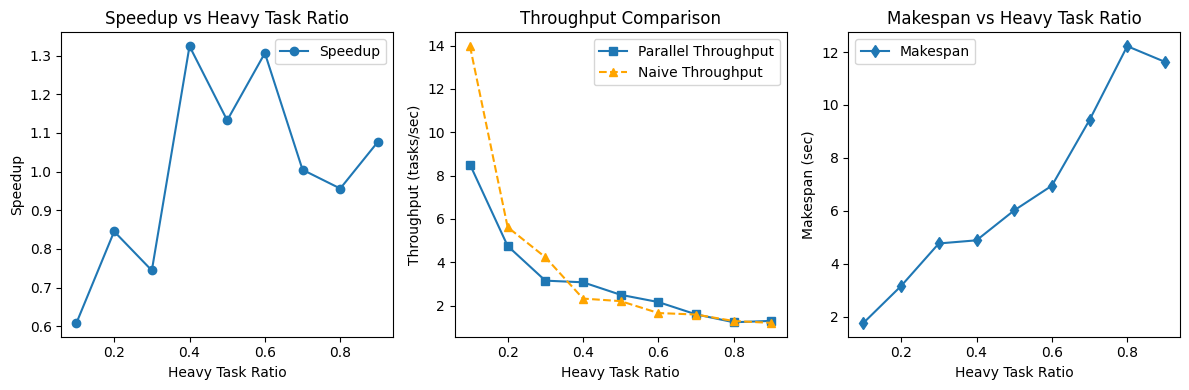

In [ ]:
import matplotlib.pyplot as plt
from collections import defaultdict

def run_multiple_experiments(k: int, num_tasks: int = 25):
    """
    Runs experiments for different heavy-to-light ratios from 0.1 to 0.9 and plots results.
    """
    ratios = [round(i / 10, 1) for i in range(1, 10)]  # 0.1 to 0.9
    speedups = []
    parallel_throughputs = []
    naive_throughputs = []
    makespans = []
    config = defaultdict(dict)

    for ratio in ratios:
        heavy_count = int(num_tasks * ratio)
        light_count = num_tasks - heavy_count
        print(f"Running experiment with {heavy_count} heavy and {light_count} light tasks.")

        evaluator = run_experiment(k=k, heavy_light_ratio=(heavy_count, light_count), num_tasks=num_tasks)

        # Debugging outputs
        # config = {ratio:[]}
        print(f"Speedup for ratio {ratio}: {evaluator.speedup_makespan:.2f}")
        print(f"Parallel Throughput for ratio {ratio}: {evaluator.throughput_makespan:.2f}")
        print(f"Naive Throughput for ratio {ratio}: {num_tasks / evaluator.naive_makespan:.2f}")
        print(f"Makespan for ratio {ratio}: {evaluator.parallel_makespan:.2f}")

        config[ratio] = {'speedup':evaluator.speedup_makespan}
        config[ratio]['parallel_throughput'] = evaluator.throughput_makespan
        config[ratio]['naive_throughput'] = num_tasks / evaluator.naive_makespan
        config[ratio]['makespan'] = evaluator.parallel_makespan

        # Store metrics
        speedups.append(evaluator.speedup_makespan)
        parallel_throughputs.append(evaluator.throughput_makespan)
        naive_throughputs.append(num_tasks / evaluator.naive_makespan)  # Non-parallel throughput
        makespans.append(evaluator.parallel_makespan)

    print()
    print(f"Speedups: {speedups}")
    print(f"Parallel Throughputs: {parallel_throughputs}")
    print(f"Naive Throughputs: {naive_throughputs}")
    print(f"Makespans: {makespans}")
    print()
    print(f"The best configuration is {max(config.values(), key=lambda x: x['speedup'])}")
    print()

    # Plot results
    plt.figure(figsize=(12, 4))

    # Speedup Plot
    plt.subplot(1, 3, 1)
    plt.plot(ratios, speedups, marker='o', linestyle='-', label='Speedup')
    plt.xlabel("Heavy Task Ratio")
    plt.ylabel("Speedup")
    plt.title("Speedup vs Heavy Task Ratio")
    plt.legend()

    # Throughput Plot (Parallel vs Naive)
    plt.subplot(1, 3, 2)
    plt.plot(ratios, parallel_throughputs, marker='s', linestyle='-', label='Parallel Throughput')
    plt.plot(ratios, naive_throughputs, marker='^', linestyle='--', label='Naive Throughput', color='orange')
    plt.xlabel("Heavy Task Ratio")
    plt.ylabel("Throughput (tasks/sec)")
    plt.title("Throughput Comparison")
    plt.legend()

    # Makespan Plot
    plt.subplot(1, 3, 3)
    plt.plot(ratios, makespans, marker='d', linestyle='-', label='Makespan')
    plt.xlabel("Heavy Task Ratio")
    plt.ylabel("Makespan (sec)")
    plt.title("Makespan vs Heavy Task Ratio")
    plt.legend()

    plt.tight_layout()
    plt.show()

# Run experiments with different heavy-to-light ratios and plot results
run_multiple_experiments(k=2, num_tasks=15)

In [ ]:
import time
import torch
import threading
import queue
import os

# Suppose this is your existing Node class (abbreviated here).
# from your_code import Node

def torch_long_running_task(name: str, size: int = 2000, device: str = 'cpu'):
    """
    A sample function to simulate a time-consuming PyTorch operation.
    Performs a large matrix multiplication on the specified device.
    Prints start/end times so we can see parallel behavior.

    Args:
        name (str): A label for logging.
        size (int): Dimension for the square matrices to multiply.
        device (str): 'cpu' or 'cuda' (if available).
    """
    start = time.time()
    print(f"[{name}] Starting at {start:.2f} on device={device}")

    # Create two random Tensors of shape (size, size) on 'device'
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)

    # Perform a matrix multiplication to simulate a heavy compute load
    c = torch.matmul(a, b)

    # If running on GPU, synchronize to ensure the operation completes
    if device == 'cuda':
        torch.cuda.synchronize()

    end = time.time()
    elapsed = end - start
    print(f"[{name}] Finished at {end:.2f}, Elapsed: {elapsed:.2f} seconds (device={device})")

    return f"[{name}] done (shape={c.shape}, device={device}, time={elapsed:.2f}s)"

def test_parallel_nodes():
    print("Discovering nodes...")
    nodes = Node.discover_nodes(disjoint=True)

    if len(nodes) < 2:
        print("Not enough nodes discovered. Exiting.")
        return

    node1 = nodes[0]
    node2 = nodes[1]
    print(f"Using Node1: {node1}, Node2: {node2}")

    # Decide on device for each node (Node might have GPU set, or just CPU)
    device1 = 'cuda' if node1.gpu is not None and torch.cuda.is_available() else 'cpu'
    device2 = 'cuda' if node2.gpu is not None and torch.cuda.is_available() else 'cpu'

    # Assign a PyTorch matrix-mult task to each node
    print("\nAssigning PyTorch tasks...")
    res_queue1 = node1.assign_task(torch_long_running_task, "TorchTask-A", 2000, device1)
    res_queue2 = node2.assign_task(torch_long_running_task, "TorchTask-B", 2000, device2)

    print("Waiting for tasks to complete...")
    result1 = res_queue1.get()
    result2 = res_queue2.get()

    node1.stop()
    node2.stop()

    print("\nResults:")
    print(" -", result1)
    print(" -", result2)


def main():
    test_parallel_nodes()

if __name__ == "__main__":
    main()

Discovering nodes...
Using Node1: Node(CPU-0, cpus=(0,), gpu=None), Node2: Node(CPU-1, cpus=(1,), gpu=None)

Assigning PyTorch tasks...
Waiting for tasks to complete...
[TorchTask-A] Starting at 1739180018.84 on device=cpu
[TorchTask-B] Starting at 1739180018.85 on device=cpu
[TorchTask-B] Finished at 1739180019.75, Elapsed: 0.91 seconds (device=cpu)
[TorchTask-A] Finished at 1739180019.91, Elapsed: 1.07 seconds (device=cpu)

Results:
 - [TorchTask-A] done (shape=torch.Size([2000, 2000]), device=cpu, time=1.07s)
 - [TorchTask-B] done (shape=torch.Size([2000, 2000]), device=cpu, time=0.91s)


In [ ]:
import os
import time
import torch
import threading
import queue
from typing import Callable, List
import random




########################################
# Heavy Torch Function for demonstration
########################################
def heavy_torch_op(name: str, size: int = 2000, device: str = 'cpu'):
    """
    Performs a large matrix multiplication to simulate a heavy compute workload.
    """
    start = time.time()
    print(f"[{name}] Starting on device={device} at {start:.2f}")

    # Create random Tensors
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)

    # Do a matrix multiply
    c = torch.matmul(a, b)

    if device.startswith('cuda'):
        torch.cuda.synchronize()  # ensure kernel completes before timing

    end = time.time()
    elapsed = end - start
    print(f"[{name}] Finished at {end:.2f}, Elapsed: {elapsed:.2f}s (device={device})")

    # Return some info
    return f"{name} done (shape={c.shape}, device={device}, time={elapsed:.2f}s)"


########################################
# Compare Naive vs. Parallel Node Execution
########################################
def run_naive(tasks):
    """
    Runs tasks sequentially in the main thread (naive approach).
    tasks: list of (function, args, kwargs)
    """
    print("\n[Naive Execution] Starting...")
    start = time.time()
    results = []
    for i, (func, args, kwargs) in enumerate(tasks):
        r = func(*args, **kwargs)  # run inline, blocking
        results.append(r)
    end = time.time()
    elapsed = end - start
    print(f"[Naive Execution] Done. Total elapsed: {elapsed:.2f}s\n")
    return results, elapsed


def run_parallel_nodes(tasks, nodes):
    """
    Runs tasks in parallel using multiple Node objects.
    tasks: list of (function, args, kwargs)
    nodes: list of Node objects
    """
    print("\n[Parallel Execution] Starting...")
    start = time.time()

    # We'll assign each task to one node (if # tasks <= # nodes)
    # or reuse nodes if we have more tasks than nodes.
    result_queues = []
    for i, (func, args, kwargs) in enumerate(tasks):
        node = nodes[i % len(nodes)]  # pick a node in round-robin
        rq = node.assign_task(func, *args, **kwargs)
        result_queues.append(rq)

    # Collect results
    results = []
    for rq in result_queues:
        r = rq.get()  # block until the task is done
        results.append(r)

    end = time.time()
    elapsed = end - start
    print(f"[Parallel Execution] Done. Total elapsed: {elapsed:.2f}s\n")
    return results, elapsed


def main():
    # 1) Create a set of tasks (function + args)
    # For demonstration, let's generate 4 tasks that do a matrix multiply.
    # We'll randomize the matrix size a bit so they differ slightly.
    tasks = []
    for i in range(4):
        size = random.randint(1800, 2200)  # a bit of variety
        name = f"Task-{i+1}"
        tasks.append((heavy_torch_op, (name, size), {'device': 'cuda'}))  # We'll keep device='cpu' for the naive test

    # 2) Run them naively (sequentially)
    naive_results, naive_time = run_naive(tasks)

    # 3) Discover nodes for parallel approach
    # If you have a GPU, it will appear here. Otherwise, you'll see multiple CPU nodes.
    nodes = Node.discover_nodes(disjoint=True)
    if not nodes:
        print("No nodes discovered! Exiting parallel test.")
        return

    # For parallel test, let's do the same tasks but allow them to run on their assigned nodes
    # We can choose device based on the node's GPU, or keep CPU.
    # Let's create the tasks again but pick device by node's GPU availability.
    # We'll create a new tasks list for the parallel approach:
    parallel_tasks = []
    for i in range(4):
        size = random.randint(1800, 2200)
        name = f"Par-Task-{i+1}"
        # We'll decide device at runtime, so we'll store 'device'='cpu' or 'cuda' in the node assign call:
        # Actually, let's just define the function+args now, but we won't set device here.
        # We'll specify device in a moment by partial application, or a closure.
        # For simplicity, let's just do CPU again, or we can do a small trick:
        parallel_tasks.append((heavy_torch_op, (name, size), {}))  # device to be set in the code.

    # We'll pick a node for each task. If it has a GPU, we set device='cuda'.
    # We'll do that in run_parallel_nodes to keep it consistent.

    # Actually let's do a custom approach:
    # We'll modify the tasks list so that each item has the correct device
    final_parallel_tasks = []
    for i, tinfo in enumerate(parallel_tasks):
        func, args, kwargs = tinfo
        node = nodes[i % len(nodes)]  # node to be used
        device = 'cuda' if (node.gpu is not None and torch.cuda.is_available()) else 'cpu'
        # Make a new args tuple
        name, size = args
        new_args = (name, size)
        new_kwargs = {'device': device}
        final_parallel_tasks.append((func, new_args, new_kwargs))

    # 4) Run them in parallel on the discovered nodes
    parallel_results, parallel_time = run_parallel_nodes(final_parallel_tasks, nodes)

    # 5) Compare times
    print(f"Naive total time:    {naive_time:.2f}s")
    print(f"Parallel total time: {parallel_time:.2f}s")

    # 6) Shut down nodes
    for n in nodes:
        n.stop()

    # Print final results
    print("\nNaive results:")
    for r in naive_results:
        print("  ", r)

    print("\nParallel results:")
    for r in parallel_results:
        print("  ", r)


if __name__ == "__main__":
    main()



[Naive Execution] Starting...
[Task-1] Starting on device=cuda at 1739180524.36
[Task-1] Finished at 1739180524.38, Elapsed: 0.02s (device=cuda)
[Task-2] Starting on device=cuda at 1739180524.38
[Task-2] Finished at 1739180524.39, Elapsed: 0.00s (device=cuda)
[Task-3] Starting on device=cuda at 1739180524.39
[Task-3] Finished at 1739180524.39, Elapsed: 0.01s (device=cuda)
[Task-4] Starting on device=cuda at 1739180524.39
[Task-4] Finished at 1739180524.40, Elapsed: 0.01s (device=cuda)
[Naive Execution] Done. Total elapsed: 0.05s


[Parallel Execution] Starting...
[Par-Task-2] Starting on device=cpu at 1739180524.42
[Par-Task-1] Starting on device=cuda at 1739180524.43
[Par-Task-1] Finished at 1739180524.44, Elapsed: 0.01s (device=cuda)
[Par-Task-3] Starting on device=cuda at 1739180524.44
[Par-Task-3] Finished at 1739180524.46, Elapsed: 0.01s (device=cuda)
[Par-Task-2] Finished at 1739180524.99, Elapsed: 0.57s (device=cpu)
[Par-Task-4] Starting on device=cpu at 1739180525.02
[Par-Task

In [ ]:
import os
import time
import torch
import threading
import queue
from typing import Callable, List
import random
# import seed

random.seed(42)



########################################
# Heavy Torch Function for demonstration
########################################
def heavy_torch_op(name: str, size: int = 2000, device: str = 'cpu'):
    """
    Performs a large matrix multiplication to simulate a heavy compute workload.
    """
    start = time.time()
    print(f"[{name}] Starting on device={device} at {start:.2f}")

    # Create random Tensors
    a = torch.randn(size, size, device=device)
    b = torch.randn(size, size, device=device)

    # Do a matrix multiply
    c = torch.matmul(a, b)

    if device.startswith('cuda'):
        torch.cuda.synchronize()  # ensure kernel completes before timing

    end = time.time()
    elapsed = end - start
    print(f"[{name}] Finished at {end:.2f}, Elapsed: {elapsed:.2f}s (device={device})")

    # Return some info
    return f"{name} done (shape={c.shape}, device={device}, time={elapsed:.2f}s)"


########################################
# Compare Naive vs. Parallel Node Execution
########################################
def run_naive(tasks):
    """
    Runs tasks sequentially in the main thread (naive approach).
    tasks: list of (function, args, kwargs)
    """
    print("\n[Naive Execution] Starting...")
    start = time.time()
    results = []
    for i, (func, args, kwargs) in enumerate(tasks):
        r = func(*args, **kwargs)  # run inline, blocking
        results.append(r)
    end = time.time()
    elapsed = end - start
    print(f"[Naive Execution] Done. Total elapsed: {elapsed:.2f}s\n")
    return results, elapsed


def run_parallel_nodes(tasks, nodes):
    """
    Runs tasks in parallel using multiple Node objects.
    tasks: list of (function, args, kwargs)
    nodes: list of Node objects
    """
    print("\n[Parallel Execution] Starting...")
    start = time.time()

    # We'll assign each task to one node (if # tasks <= # nodes)
    # or reuse nodes if we have more tasks than nodes.
    result_queues = []
    for i, (func, args, kwargs) in enumerate(tasks):
        node = nodes[i % len(nodes)]  # pick a node in round-robin
        rq = node.assign_task(func, *args, **kwargs)
        result_queues.append(rq)

    # Collect results
    results = []
    for rq in result_queues:
        r = rq.get()  # block until the task is done
        results.append(r)

    end = time.time()
    elapsed = end - start
    print(f"[Parallel Execution] Done. Total elapsed: {elapsed:.2f}s\n")
    return results, elapsed


def main():
    # 1) Create a set of tasks (function + args)
    # For demonstration, let's generate 4 tasks that do a matrix multiply.
    # We'll randomize the matrix size a bit so they differ slightly.
    tasks = []
    for i in range(4):
        size = random.randint(1000, 3200)  # a bit of variety
        # size = random
        name = f"Task-{i+1}"
        tasks.append((heavy_torch_op, (name, size), {'device': 'cpu'}))  # We'll keep device='cpu' for the naive test

    # 2) Run them naively (sequentially)
    naive_results, naive_time = run_naive(tasks)

    # 3) Discover nodes for parallel approach
    # If you have a GPU, it will appear here. Otherwise, you'll see multiple CPU nodes.
    nodes = Node.discover_nodes(disjoint=True)
    print(nodes)
    if not nodes:
        print("No nodes discovered! Exiting parallel test.")
        return

    # For parallel test, let's do the same tasks but allow them to run on their assigned nodes
    # We can choose device based on the node's GPU, or keep CPU.
    # Let's create the tasks again but pick device by node's GPU availability.
    # We'll create a new tasks list for the parallel approach:
    parallel_tasks = []
    for i in range(4):
        size = random.randint(1000, 3200)
        name = f"Par-Task-{i+1}"
        # We'll decide device at runtime, so we'll store 'device'='cpu' or 'cuda' in the node assign call:
        # Actually, let's just define the function+args now, but we won't set device here.
        # We'll specify device in a moment by partial application, or a closure.
        # For simplicity, let's just do CPU again, or we can do a small trick:
        parallel_tasks.append((heavy_torch_op, (name, size), {}))  # device to be set in the code.

    # We'll pick a node for each task. If it has a GPU, we set device='cuda'.
    # We'll do that in run_parallel_nodes to keep it consistent.

    # Actually let's do a custom approach:
    # We'll modify the tasks list so that each item has the correct device
    final_parallel_tasks = []
    for i, tinfo in enumerate(parallel_tasks):
        func, args, kwargs = tinfo
        node = nodes[i % len(nodes)]  # node to be used
        device = 'cuda' if (node.gpu is not None and torch.cuda.is_available()) else 'cpu'
        # Make a new args tuple
        name, size = args
        new_args = (name, size)
        new_kwargs = {'device': device}
        final_parallel_tasks.append((func, new_args, new_kwargs))

    # 4) Run them in parallel on the discovered nodes
    parallel_results, parallel_time = run_parallel_nodes(final_parallel_tasks, nodes)

    # 5) Compare times
    print(f"Naive total time:    {naive_time:.2f}s")
    print(f"Parallel total time: {parallel_time:.2f}s")

    # 6) Shut down nodes
    for n in nodes:
        n.stop()

    # Print final results
    print("\nNaive results:")
    for r in naive_results:
        print("  ", r)

    print("\nParallel results:")
    for r in parallel_results:
        print("  ", r)


if __name__ == "__main__":
    main()



[Naive Execution] Starting...
[Task-1] Starting on device=cpu at 1739264751.07
[Task-1] Finished at 1739264751.30, Elapsed: 0.22s (device=cpu)
[Task-2] Starting on device=cpu at 1739264751.30
[Task-2] Finished at 1739264751.36, Elapsed: 0.06s (device=cpu)
[Task-3] Starting on device=cpu at 1739264751.36
[Task-3] Finished at 1739264751.72, Elapsed: 0.36s (device=cpu)
[Task-4] Starting on device=cpu at 1739264751.73
[Task-4] Finished at 1739264752.04, Elapsed: 0.31s (device=cpu)
[Naive Execution] Done. Total elapsed: 0.97s

[Node(CPU-0, cpus=(0,), gpu=None), Node(CPU-1, cpus=(1,), gpu=None)]

[Parallel Execution] Starting...
[Par-Task-2] Starting on device=cpu at 1739264752.04
[Par-Task-1] Starting on device=cpu at 1739264752.05
[Par-Task-2] Finished at 1739264752.34, Elapsed: 0.30s (device=cpu)
[Par-Task-4] Starting on device=cpu at 1739264752.35
[Par-Task-4] Finished at 1739264752.53, Elapsed: 0.18s (device=cpu)
[Par-Task-1] Finished at 1739264752.55, Elapsed: 0.51s (device=cpu)
[Par-